activate conda environment anopheles.yml

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sys
import seaborn
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

import os, io, random
import string

In [3]:
#import files
refbase = pd.read_csv("../../data/haplotypes-NNv1.csv")
td = pd.read_csv("../1_species-groups-thresholds/sample_info.csv", index_col=0)
samples = td.index.values

In [4]:
def construct_kmer_dict(k):
    labels = []
    for i in itertools.product('ACGT', repeat=k):
        labels.append(''.join(i))
    kmerdict = dict(zip(labels, np.arange(4**k)))
    return(kmerdict)

In [5]:
def assign_combUID(haplotypes): 
    # assign IDs to unique sequences
    combuids = dict()
    for tgt, group in haplotypes.groupby(['target']):
        for (i, cons) in enumerate(group['consensus'].unique()):
            combuids[str(tgt)+cons] = '{}-{}'.format(tgt, i)
    haplotypes['combUID'] = (haplotypes.target.astype('str') + haplotypes.consensus).replace(combuids)
    return(haplotypes)

In [6]:
def sample_kmer_table(k, seq, no_amp, x):
    kmerdict = construct_kmer_dict(k)
    table = np.zeros((no_amp, x, 4**k), dtype='int')
    for r in seq.index:
        combid = str.split(seq.loc[r,'combUID'], '-')
        t, u = int(combid[0]), int(combid[1])
        sq = seq.loc[r,'consensus']
        for i in np.arange(len(sq)-(k-1)):
            table[t,u,kmerdict[sq[i:i+k]]] += 1
    return(table)

In [7]:
def construct_unique_kmer_array(k, hap, no_amp):
    # assign IDs to unique sequences if column combUID does not exist
    if not 'combUID' in hap.columns:
        hap = assign_combUID(hap)
    
    maxallele = hap.groupby('target')['combUID'].nunique().max()
    
    combUIDunique = hap[['combUID', 'consensus']].drop_duplicates()
    
    kmercombUID = sample_kmer_table(k, combUIDunique, no_amp, maxallele)
    
    return(kmercombUID, hap)

In [8]:
#Assign combUIDs to refdatabase
refbase = assign_combUID(refbase)
#Add column with zygosity information
#Add allelic zygosity
zygosity = 2/refbase.groupby(['s_Sample', 'target'])['combUID'].nunique()
zygosity = pd.DataFrame(zygosity).reset_index()
zygosity_dict = dict(zip(zygosity.s_Sample + zygosity.target.astype('str'), zygosity.combUID))
refbase['zygosity'] = (refbase.s_Sample + refbase.target.astype('str')).replace(zygosity_dict)
#Check that all samples sum to 2
(refbase.groupby(['s_Sample', 'target'])['zygosity'].sum()==2).all()

True

In [9]:
#Include group information in refbase dataframe
tdfdict = dict(zip(td.index, td.fine_sgp))
tdidict = dict(zip(td.index, td.intermediate_sgp))
tdcdict = dict(zip(td.index, td.coarse_sgp))
refbase['fine_sgp'] = refbase.s_Sample.map(tdfdict)
refbase['intermediate_sgp'] = refbase.s_Sample.map(tdidict)
refbase['coarse_sgp'] = refbase.s_Sample.map(tdcdict)

In [10]:
#make refbase entries categorical
refbase['fine_sgp'] = pd.Categorical(refbase['fine_sgp'], ['Anopheles_marshallii_complex', 'Anopheles_marshallii_cp_sp1',
       'Anopheles_theileri', 'Anopheles_moucheti', 'Anopheles_jebudensis',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus', 'Anopheles_rampae',
       'Anopheles_maculatus_A', 'Anopheles_maculatus_B',
       'Anopheles_maculipalpis', 'Anopheles_annularis',
       'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_coluzzii', 'Anopheles_arabiensis',
       'Anopheles_gambiae_cp_sp1', 'Anopheles_quadriannulatus',
       'Anopheles_melas', 'Anopheles_merus', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_A', 'Anopheles_balabacensis', 'Anopheles_cracens',
       'Anopheles_koliensis', 'Anopheles_farauti',
       'Anopheles_punctulatus', 'Anopheles_tessellatus',
       'Anopheles_coustani_cp_cl3', 'Anopheles_coustani_cp_cl2', 
       'Anopheles_coustani_cp_cl1', 'Anopheles_hyrcanus_gp_sp1', 
       'Anopheles_hyrcanus_gp_sp2', 'Anopheles_sinensis',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_gp_sp3',
       'Anopheles_nili_gp_sp2', 'Anopheles_nili_gp_sp1',
       'Anopheles_carnevalei', 'Anopheles_vinckei', 'Anopheles_dureni',
       'Anopheles_aquasalis', 'Anopheles_oryzalimnetes',
       'Anopheles_darlingi', 'Anopheles_albimanus', 'Anopheles_cruzii',
       'Anopheles_bellator'], ordered=True)
refbase['intermediate_sgp'] = pd.Categorical(refbase['intermediate_sgp'],['Anopheles_marshallii_group', 'Anopheles_moucheti_group',
       'Myzomyia_sp1', 'Anopheles_gabonensis', 'Anopheles_funestus',
       'Anopheles_rhodesiensis', 'Anopheles_minimus_A',
       'Anopheles_culicifacies', 'Anopheles_aconitus',
       'Anopheles_maculatus_group', 'Anopheles_maculipalpis',
       'Anopheles_annularis', 'Anopheles_jamesii', 'Anopheles_stephensi',
       'Anopheles_gambiae_complex', 'Anopheles_christyi',
       'Anopheles_sundaicus_complex', 'Anopheles_vagus',
       'Anopheles_dirus_complex', 'Anopheles_punctulatus_group',
       'Anopheles_tessellatus', 'Anopheles_coustani_complex',
       'Anopheles_hyrcanus_gp_sp1', 'Anopheles_sinensis_group',
       'Anopheles_barbirostris', 'Anopheles_atroparvus',
       'Anopheles_implexus', 'Anopheles_nili_group', 'Anopheles_vinckei',
       'Anopheles_dureni', 'Anopheles_aquasalis',
       'Anopheles_oryzalimnetes', 'Anopheles_darlingi',
       'Anopheles_albimanus', 'Kerteszia_subgenus'], ordered=True)
refbase['coarse_sgp'] = pd.Categorical(refbase['coarse_sgp'], ['Myzomyia_Neocellia_series', 'Pyretophorus_series',
       'Neomyzomyia_series_I', 'Myzorhynchus_series', 'Christya_series',
       'Neomyzomyia_series_II', 'Neomyzomyia_series_III',
       'Nyssorhynchus_subgenus', 'Kerteszia_subgenus'], ordered=True)

In [11]:
#find the nearest neighbours of a given individual at a given target
def individual_combUID_dist(amp, a, samp1, refkmers, sampleneighbours):
    #sequences from individual
    sqic = amp.loc[amp.s_Sample == samp1, 'combUID'].unique()
    #dropout sample from haplotypes
    ampf = amp.copy()
    ampf.drop(ampf.loc[ampf.s_Sample == samp1].index, inplace=True)
    #allowed matching sequences
    sqmc = ampf['combUID'].str.split('-', expand=True)[1]
    #array of allowed matches
    sqar = np.isin(np.arange(refkmers.shape[1]).astype('str'), sqmc)
    #zygosity of individual
    z = 2/len(sqic)
    #compute allelic distances per haplotype
    ampf['neighbours'] = 0
    for sq in sqic:
        s = int(sq.split('-')[1])
        #compute distances normalised for sequence length
        dists = np.sum(np.abs(refkmers[a,:,:] - refkmers[a,s,:]),axis=1)/np.sum(refkmers[a,:,:] + refkmers[a,s,:], axis=1)
        #mask invalid comparisons
        dists = np.where(sqar, dists, np.nan)
        #find minimisers
        minisq = np.arange(refkmers.shape[1])[dists==np.nanmin(dists)]
        minisqcb = np.core.defchararray.add(np.array(['{}-'.format(a)]), minisq.astype(str))
        #include neighbour column weighed by zygosity
        ampf.loc[:,'neighbours'] += ampf.loc[:,'combUID'].isin(minisqcb)
    neighbours = pd.DataFrame(ampf.groupby('s_Sample')['neighbours'].sum())
    ndict = dict(zip(neighbours.index, neighbours.neighbours))
    sampleneighbours[a] = sampleneighbours.index.map(ndict)
    return(sampleneighbours)

In [12]:
#sampleneighboursagam = pd.DataFrame(index=td.index, columns=np.arange(62))
sampleneighboursamou = pd.DataFrame(index=td.index, columns=np.arange(62))
sampleneighboursagam = pd.DataFrame(index=td.index, columns=np.arange(62))

In [13]:
def construct_assignment_array(refbase, refkmers, sampleneighbours, name):

    #restrict to per amplicon
    for a in np.arange(62):
        amp = refbase.loc[refbase.target == a]
        if np.isin(name, amp.s_Sample):
            sampleneighbours = individual_combUID_dist(amp, a, name, refkmers, sampleneighbours)

        print("amplicon ", a, " done")
    return(sampleneighbours)
            
    

In [14]:
#Make array unique 8mers
maxallele = refbase.groupby('target')['combUID'].nunique().max()
combUIDunique = refbase[['combUID', 'consensus']].drop_duplicates()
ref8mers = sample_kmer_table(8, combUIDunique, 62, maxallele)

In [15]:
sampleneighboursamou = construct_assignment_array(refbase, ref8mers, sampleneighboursamou, 'Amou-2-3')

amplicon  0  done
amplicon  1  done
amplicon  2  done
amplicon  3  done
amplicon  4  done
amplicon  5  done
amplicon  6  done
amplicon  7  done
amplicon  8  done
amplicon  9  done
amplicon  10  done
amplicon  11  done
amplicon  12  done
amplicon  13  done
amplicon  14  done
amplicon  15  done
amplicon  16  done
amplicon  17  done
amplicon  18  done
amplicon  19  done
amplicon  20  done
amplicon  21  done
amplicon  22  done
amplicon  23  done
amplicon  24  done
amplicon  25  done
amplicon  26  done
amplicon  27  done
amplicon  28  done
amplicon  29  done
amplicon  30  done
amplicon  31  done
amplicon  32  done
amplicon  33  done
amplicon  34  done
amplicon  35  done
amplicon  36  done
amplicon  37  done
amplicon  38  done
amplicon  39  done
amplicon  40  done
amplicon  41  done
amplicon  42  done
amplicon  43  done
amplicon  44  done
amplicon  45  done
amplicon  46  done
amplicon  47  done
amplicon  48  done
amplicon  49  done
amplicon  50  done
amplicon  51  done
amplicon  52  done
amp

In [16]:
sampleneighboursagam = construct_assignment_array(refbase, ref8mers, sampleneighboursagam, 'Agam-35')

amplicon  0  done
amplicon  1  done
amplicon  2  done
amplicon  3  done
amplicon  4  done
amplicon  5  done
amplicon  6  done
amplicon  7  done
amplicon  8  done
amplicon  9  done
amplicon  10  done
amplicon  11  done
amplicon  12  done
amplicon  13  done
amplicon  14  done
amplicon  15  done
amplicon  16  done
amplicon  17  done
amplicon  18  done
amplicon  19  done
amplicon  20  done
amplicon  21  done
amplicon  22  done
amplicon  23  done
amplicon  24  done
amplicon  25  done
amplicon  26  done
amplicon  27  done
amplicon  28  done
amplicon  29  done
amplicon  30  done
amplicon  31  done
amplicon  32  done
amplicon  33  done
amplicon  34  done
amplicon  35  done
amplicon  36  done
amplicon  37  done
amplicon  38  done
amplicon  39  done
amplicon  40  done
amplicon  41  done
amplicon  42  done
amplicon  43  done
amplicon  44  done
amplicon  45  done
amplicon  46  done
amplicon  47  done
amplicon  48  done
amplicon  49  done
amplicon  50  done
amplicon  51  done
amplicon  52  done
amp

In [17]:
sampleneighboursagam.isin([0,1,2, np.nan]).all().all()

True

In [ ]:
sampleneighboursamou.isin([0,1,2, np.nan]).all().all()

In [18]:
maskgam = sampleneighboursagam.isnull()
maskmou = sampleneighboursamou.isnull()

In [19]:
for sn in [sampleneighboursagam,sampleneighboursamou]:
    for i in np.arange(62):
        sn.loc[sn[i].isnull(), i] = 0

In [21]:
for sn in [sampleneighboursagam, sampleneighboursamou]:
     sn = sn.astype('int')

In [22]:
#dropout the sample itself from the reference set
for name, sn, mn in zip(['Agam-35', 'Amou-2-3'], [sampleneighboursagam, sampleneighboursamou], [maskgam, maskmou]):
    sn.drop(name, inplace=True)
    mn.drop(name, inplace=True)

In [25]:
splines = [0.1,3,5,21,27,28,39,43,54,55,60,63.9]
ilines = [0.1,3,5,54,55,60,63.9]
clines = [5,63.9]

In [26]:
flinesm = [0.1,9,10,14,18,20,21,22,26,29,32,33,35,39,41,42,46,50,53,54.9]
ilinesm = [0.1,14,20,21,22,26,29,32,33,35,42,46,50,53,54.9]
clinesm = [0.1,54.9]

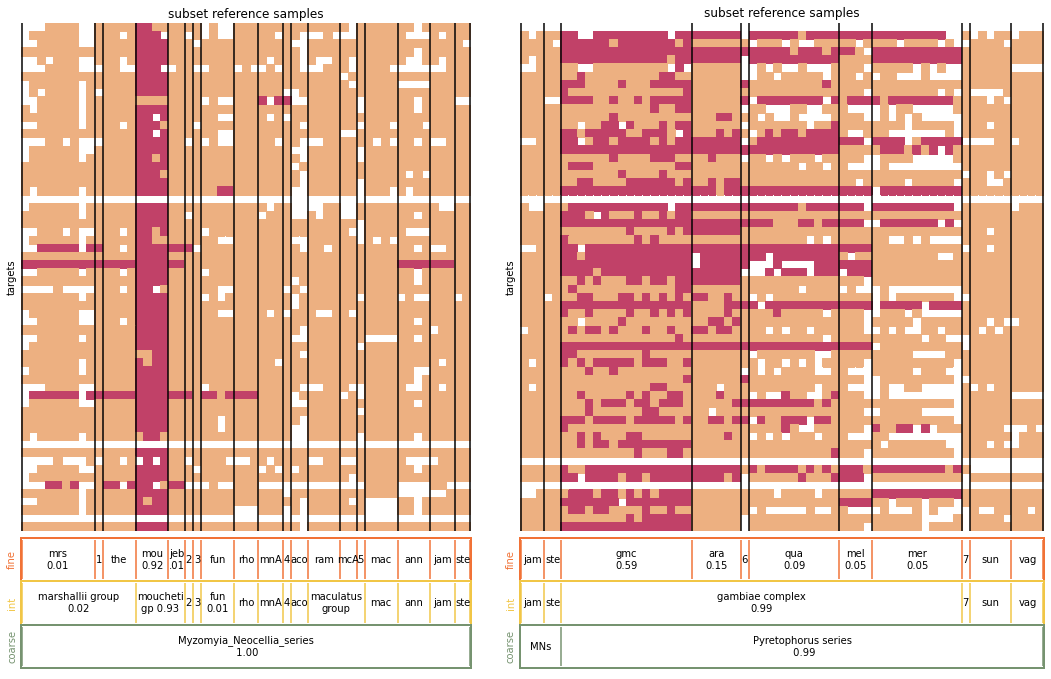

In [64]:
fig, ax= plt.subplots(4,2,figsize = (18.33,12), sharex='col', gridspec_kw={'height_ratios': [12,1,1,1], 'width_ratios': [5.15,6]})
for sampleneighbours, mask, i, idxs, idxe in zip([sampleneighboursamou, sampleneighboursagam], [maskmou, maskgam], [0,1], 
                                    [0, 51], [55, 115]):


    snsplot = seaborn.heatmap(sampleneighbours.iloc[idxs:idxe,:].T>0, square = True, vmax = 2, ax=ax[0,i], 
                          mask=mask.iloc[idxs:idxe,:].T, cbar=False, cmap='flare', yticklabels=False).set(
        ylabel='targets', title='subset reference samples', xlabel='')
for s in splines:
    ax[0,1].vlines(s,0,62, color='k')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_ylabel('fine', color="#F17236")
for s in splines:
    ax[1,1].vlines(s,0,2, color="#F17236")

for t,p in zip(['jam', 'ste', 'gmc\n0.59', 'ara\n0.15', '6', 'qua\n0.09', 
                'mel\n0.05', 'mer\n0.05', '7', 'sun', 'vag'], 
               [1.5, 4, 13, 24, 27.4, 33.5, 41, 48.5,54.4,57.5,62]):
    ax[1,1].text(p,1,t, horizontalalignment='center', verticalalignment='center')
ax[2,1].set_xticks([])
ax[2,1].set_yticks([])
ax[2,1].set_ylabel('int', color="#F1C646")
for s in ilines:
    ax[2,1].vlines(s,0,2, color="#F1C646")
for t,p in zip(['jam', 'ste', 'gambiae complex\n0.99', '7', 'sun', 'vag'], 
               [1.5, 4, 29.5,54.4, 57.5,62]):
    ax[2,1].text(p,1,t, horizontalalignment='center', verticalalignment='center')
ax[3,1].set_xticks([])
ax[3,1].set_yticks([])
ax[3,1].set_ylabel('coarse', color="#769370")
for s in clines:
    ax[3,1].vlines(s,0,2, color="#769370")
for t,p in zip(['MNs','Pyretophorus series\n 0.99'], [2.5,34.5]):
    ax[3,1].text(p,1,t, horizontalalignment='center', verticalalignment='center')

for s in flinesm:
    ax[0,0].vlines(s,0,62, color='k')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_ylabel('fine', color="#F17236")
for s in flinesm:
    ax[1,0].vlines(s,0,2, color="#F17236")

for t,p in zip(['mrs\n0.01', '1', 'the', 'mou\n0.92', 'jeb\n.01', '2', '3', 'fun', 'rho', 
                'mnA', '4', 'aco', 'ram', 'mcA', '5', 'mac', 'ann', 'jam', 'ste'], 
               [4.5,9.5,12,16,19,20.5,21.5,24,27.5,30.5,32.5,34,37,40,41.5,44,48,51.5,54]):
    ax[1,0].text(p,1,t, horizontalalignment='center', verticalalignment='center')
ax[2,0].set_xticks([])
ax[2,0].set_yticks([])
ax[2,0].set_ylabel('int', color="#F1C646")
for s in ilinesm:
    ax[2,0].vlines(s,0,2, color="#F1C646")
for t,p in zip(['marshallii group\n0.02', 'moucheti\ngp 0.93', '2', '3', 'fun\n0.01', 'rho', 
                'mnA', '4', 'aco', 'maculatus\ngroup', 'mac', 'ann', 'jam', 'ste'], 
               [7,17,20.5,21.5,24,27.5,30.5,32.5,34,38.5,44,48,51.5,54]):
    ax[2,0].text(p,1,t, horizontalalignment='center', verticalalignment='center')

ax[3,0].set_xticks([])
ax[3,0].set_yticks([])
ax[3,0].set_ylabel('coarse', color="#769370")
for s in clinesm:
    ax[3,0].vlines(s,0,2, color="#769370")
for t,p in zip(['Myzomyia_Neocellia_series\n 1.00'], [27.5]):
    ax[3,0].text(p,1,t, horizontalalignment='center', verticalalignment='center')
    
for n, c in enumerate(["#F17236", "#F1C646", "#769370"]):
    for p in ['left', 'right', 'top']:
        ax[n+1,0].spines[p].set_color(c)
        ax[n+1,0].spines[p].set_linewidth(2)
        ax[n+1,1].spines[p].set_color(c)
        ax[n+1,1].spines[p].set_linewidth(2)
ax[3,1].spines['bottom'].set_color("#769370")
ax[3,1].spines['bottom'].set_linewidth(2)
ax[3,0].spines['bottom'].set_color("#769370")
ax[3,0].spines['bottom'].set_linewidth(2)
   
plt.subplots_adjust(hspace=0, wspace=.1)
plt.savefig("results/combined_heatmap.png")